# Doc2Vec

This notebook attempts to use LDA to model the topics in a group of Bugzilla bugs through text analysis.

Also want to use [this approach](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) to use grid search to determine the most meaningful number of topics that exist in the text.

# Google Colaborator Setup

This section contains cells to set up the Google Colaborator environment to run this notebook. The following are needed:

* Clone the Github repository
* Install Spacy
* Install pyLDAVis

## Note: The runtime may need to be restarted after installing Spacy.

In [1]:
!pip install spacy

You are using pip version 18.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!python -m spacy download en_core_web_sm

You are using pip version 18.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /opt/tools/anaconda/lib/python3.6/site-packages/en_core_web_sm -->
    /opt/tools/anaconda/lib/python3.6/site-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [3]:
!git clone https://github.com/HSV-AI/bug-analysis.git
%cd bug-analysis

Cloning into 'bug-analysis'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 77 (delta 8), reused 3 (delta 1), pack-reused 58
Unpacking objects: 100% (77/77), done.
Checking connectivity... done.
/opt/git/bug-analysis/bug-analysis


# Loading Bugzilla Data

In [44]:
df = pd.read_parquet('data/df-xtext.parquet.gzip')

In [4]:
%run LoadData.ipynb

Loaded 2000 bugs
Created DataFrame named df
['commenters', 'component', 'id', 'product', 'reporter', 'text', 'title']


In [2]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

Now let's take a look at the content of the bugs that we retrieved.

First we can check the distribution of bugs across the defined components:

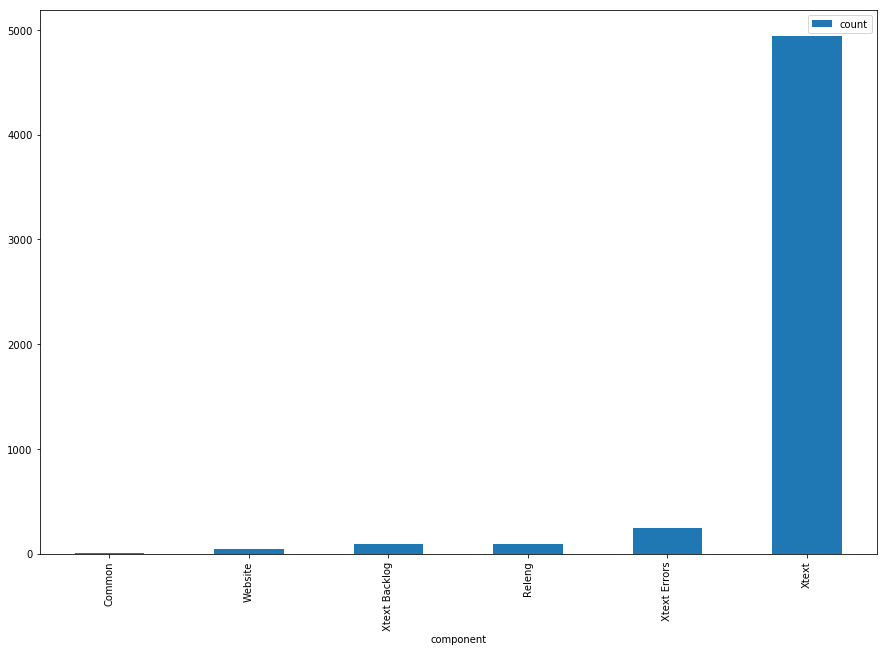

In [5]:
grouped = df.loc[:,['id','component']].groupby('component').count()
grouped.columns = ['count']
grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
plt.show()

# Cleaning Data

If you have ever worked with software bugs, you know that many of them are lacking enough information to be useful. On the other hand, some will take on a life of their own and change direction over time.

In this analysis, we will try to remove the bugs that have little text as well as those that have an overwhelming length of text.

We start by showing the distribution of the length, followed by calculation of the 3*sigma cuttof points. Seeing that this method will not work for this non-normal distribution, we use the Interquartile Range (IQR) instead.

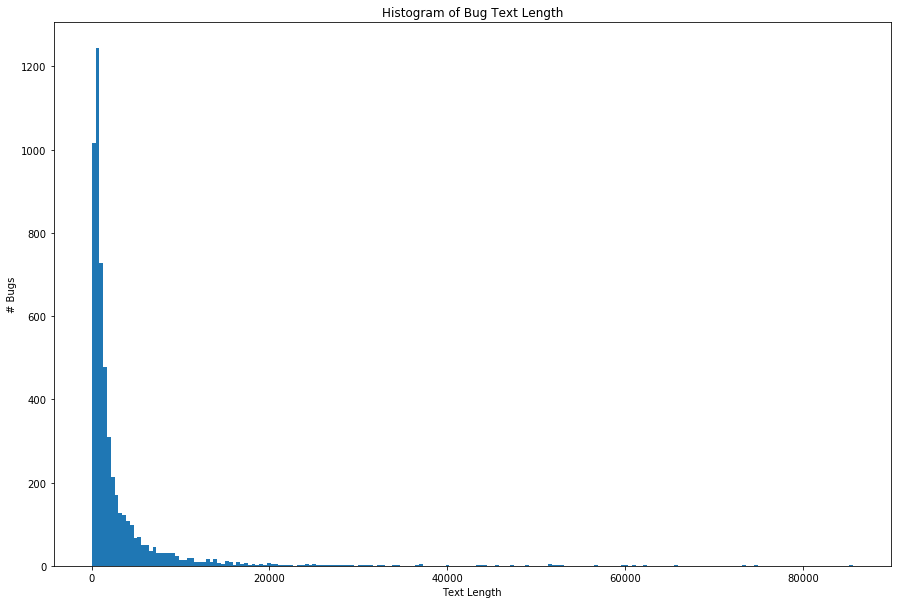

Min/Max length of any bug is 17/85577

Mean of text length is 2859
 
Standard Deviation of the text length is 5623

3 Sigma cuttoff values are lower: -14009 and upper: 19728

Interquartile Range is 2195

IQR cuttoff values are lower: -2753 and upper: 6026



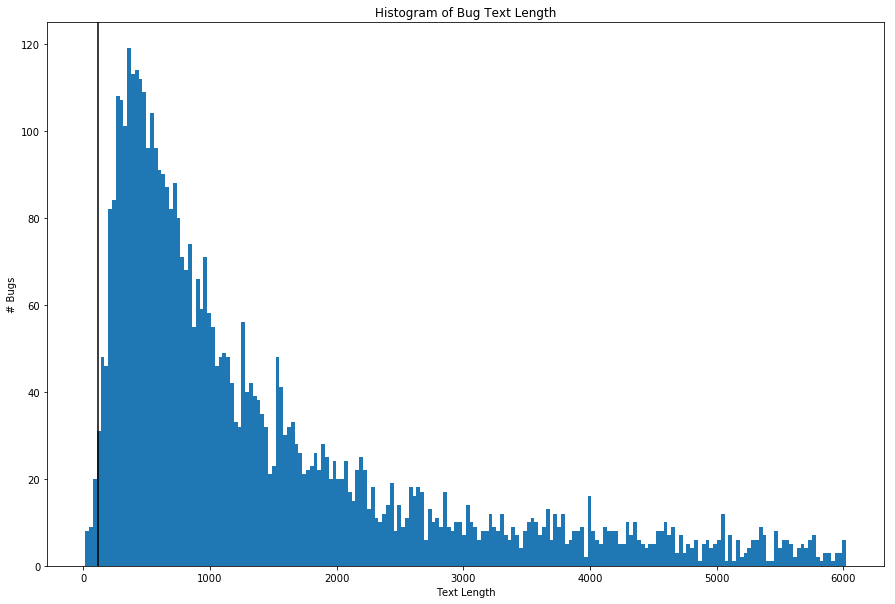

Using a manually defined lower value of 120 (See Vertical Black Line Above)

The resulting set contains 4755 bugs



In [6]:
df['length'] = df['text'].str.len()
text_arr = df.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.hist(text_arr, bins=200)
plt.show()

print('Min/Max length of any bug is %d/%d\n'%(np.min(text_arr), np.max(text_arr)))

# Find the values bounding the 98 percentile
# May want to filter these later
mean = np.mean(text_arr)
print('Mean of text length is %d\n ' % mean)
stdev = np.std(text_arr)
print('Standard Deviation of the text length is %d\n' % stdev)
#Compute 3sigma
sigma = 3*stdev
lower = mean - sigma
upper = mean + sigma

print('3 Sigma cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

q25, q75 = np.percentile(text_arr, 25), np.percentile(text_arr, 75)
iqr = q75 - q25
print('Interquartile Range is %d\n' % iqr)

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print('IQR cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]

# Let's get a look at these values
text_arr = trimmedDF.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.axvline(x=120, color='k')
plt.hist(text_arr, bins=200)
plt.show()

print("Using a manually defined lower value of 120 (See Vertical Black Line Above)\n")
lower = 120
trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]
text_arr = trimmedDF.loc[:,'length'].values
print('The resulting set contains %d bugs\n' % len(text_arr))

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [7]:
nlp = spacy.load("en_core_web_sm")

exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

filter = ['VERB', 'NOUN', 'PROPN']

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if re.fullmatch('[a-zA-Z]+', token.text):
#            if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                filtered_tokens.append(token.lemma_)
    return filtered_tokens



Let's run this tokenizer across all of our text and see how many words we have.

In [8]:
# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0

for i in trimmedDF.loc[:,'text']:
#     count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
# #     if count > 20:
#         break
print('Total word count: '+str(len(totalvocab)))
print('Total unique words: '+str(len(set(totalvocab))))

Total word count: 692375
Total unique words: 18297


# Doc2Vec


In [9]:
import gensim
def read_corpus():
  for i, row in trimmedDF.iterrows():
    yield gensim.models.doc2vec.TaggedDocument(tokenize(row['text']), [row['id']])

train_corpus = list(read_corpus())

/opt/tools/anaconda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [10]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [11]:
model.build_vocab(train_corpus)

In [12]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 45.4 s, sys: 894 ms, total: 46.3 s
Wall time: 18.9 s


In [32]:
from sklearn import cluster
from sklearn import metrics
kmeans = cluster.KMeans(n_clusters=8)
kmeans.fit(model.docvecs.vectors_docs)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [43]:
print(kmeans.cluster_centers_.shape)
print(kmeans.labels_.shape)
print(kmeans.labels_)
print(train_corpus)
l = kmeans.fit_predict(model.docvecs.vectors_docs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [42]:
print(l.shape)

(561661,)


[0 0 0 ... 0 0 5]


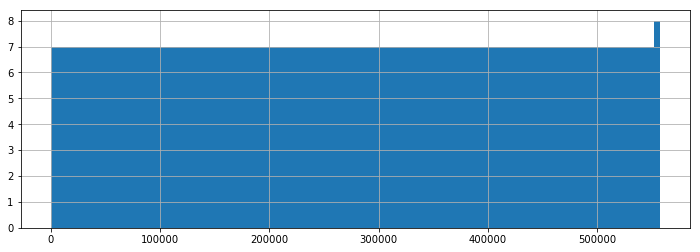

In [28]:
labels = kmeans.labels_
print(kmeans.labels_)
clusters = kmeans.labels_.tolist()
bugs = { 'title': trimmedDF.loc[:,'title'], 'text': trimmedDF.loc[:,'text'], 'cluster': clusters }
frame = pd.DataFrame(bugs, index = [clusters] , columns = ['title', 'cluster'])
frame['cluster'].value_counts().hist(cumulative=True, bins=100, figsize=(12, 4));
plt.show()

In [26]:
print("Top term per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# terms = tfidf_vectorizer.get_feature_names()

top_term = []
for i in range(7):
    print("Cluster %d:" % i, end='')
    
    for ind in order_centroids[i, :5]:
        print(ind)
#         print(terms[ind])
#         top_term.append(terms[ind])
        #print('https://bugs.eclipse.org/bugs/show_bug.cgi?id='+str(bug_ids[ind]))
        #top_term.append(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])
        #print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0])


Top term per cluster:

Cluster 0:43
40
22
7
33
Cluster 1:33
6
14
2
7
Cluster 2:26
41
28
33
11
Cluster 3:33
2
43
41
26
Cluster 4:43
33
6
2
22
Cluster 5:33
10
2
16
49
Cluster 6:33
41
2
22
46


In [13]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
text = trimmedDF.loc[trimmedDF['id'] == doc.tags[0]].iloc[0]['text']
print(doc.tags[0],text)

inferred_vector = model.infer_vector(doc.words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print()
text = trimmedDF.loc[trimmedDF['id'] == sims[1][0]].iloc[0]['text']
print(sims[1][0],text)


505971 [All diagrams] Comment shape too wide during resize and move The displayed comment shape is much wider that it actually is during resize and move. The reason is probably that its width corresponds to the required width for the text without taking line breaks into account. The displayed comment shape is much wider that it actually is during resize and move. The reason is probably that its width corresponds to the required width for the text without taking line breaks into account.

508139 [StateMachineDiagram] Resize of Entry/Exit point move them Created attachment 265564
Position of Entry-Exit point after having resized them

When resizing Entry point or exit point they are moved outside the Statemachine/State edge

See attached screenshot Created attachment 265564
Position of Entry-Exit point after having resized them

When resizing Entry point or exit point they are moved outside the Statemachine/State edge

See attached screenshot


# Visualize the Results

This section uses several methods to visualize the results of the LDA.

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

In [14]:
# Creating and fitting the tsne model to the document embeddings
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne_model = TSNE(n_jobs=4,
                  early_exaggeration=4,
                  n_components=2,
                  verbose=1,
                  random_state=2018,
                  n_iter=300)
tsne_d2v = tsne_model.fit_transform(model.docvecs.vectors_docs)

# Putting the tsne information into sq
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
# tsne_tfidf_df.columns = ["x", "y"]
tsne_d2v_df["qid"] = trimmedDF["id"].values
tsne_d2v_df["question_text"] = trimmedDF["text"].values
tsne_d2v_df["target"] = 1

In [15]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

output_notebook()
plot_d2v = bp.figure(plot_width = 800, plot_height = 700, 
                       title = "T-SNE applied to Doc2vec document embeddings",
                       tools = "pan, wheel_zoom, box_zoom, reset, hover, previewsave",
                       x_axis_type = None, y_axis_type = None, min_border = 1)

# colormap = np.array(["#6d8dca", "#d07d3c"])
colormap = np.array(["darkblue", "darkblue"])

# palette = d3["Category10"][len(tsne_tfidf_df["asset_name"].unique())]
source = ColumnDataSource(data = dict(x = tsne_d2v_df["x"], 
                                      y = tsne_d2v_df["y"],
                                      color = colormap[tsne_d2v_df["target"]],
                                      question_text = tsne_d2v_df["question_text"],
                                      qid = tsne_d2v_df["qid"],
                                      target = tsne_d2v_df["target"]))

plot_d2v.scatter(x = "x", 
                   y = "y", 
                   color="color",
                   legend = "target",
                   source = source,
                   alpha = 0.7)
hover = plot_d2v.select(dict(type = HoverTool))
hover.tooltips = {"qid": "@qid", 
                  "question_text": "@question_text", 
                  "target":"@target"}

show(plot_d2v)

Loading BokehJS ...